# Appendix


In [1]:
import sys
sys.path.append('../../src/')
from dollarparser import parse_dollar_amount
import os
import json
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(context='notebook', style='whitegrid')

In [2]:
df = pd.read_csv("processed_data/umg_all_parsed_queries.csv")
df

,index,custom_id,model,content,run_id,University,Major,Pronoun,Ranking,USNWR_Category,Funding,Region,HBCU,query_response_parsed,run_type,major_type
0,41704,task-41704,gpt-3.5-turbo-0125,"$120,000",41704,Almeda University,Biology,he,NaN,Diploma Mill,Fake,NaN,NaN,120000.0,employee,STEM
1,41705,task-41705,gpt-3.5-turbo-0125,"$110,000",41705,Almeda University,Biology,he,NaN,Diploma Mill,Fake,NaN,NaN,110000.0,employee,STEM
2,41706,task-41706,gpt-3.5-turbo-0125,"$110,000",41706,Almeda University,Biology,he,NaN,Diploma Mill,Fake,NaN,NaN,110000.0,employee,STEM
3,41707,task-41707,gpt-3.5-turbo-0125,"$110,000",41707,Almeda University,Biology,he,NaN,Diploma Mill,Fake,NaN,NaN,110000.0,employee,STEM
4,41708,task-41708,gpt-3.5-turbo-0125,"$110,000",41708,Almeda University,Biology,he,NaN,Diploma Mill,Fake,NaN,NaN,110000.0,employee,STEM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395195,32534,task-32534,gpt-4o-2024-05-13,"$103,000",32534,Williams College,Xyzzy,they,1.0,Liberal Arts,Private,Northeast,0.0,103000.0,employer,Fake-Control
395196,32535,task-32535,gpt-4o-2024-05-13,"$132,000",32535,Williams College,Xyzzy,they,1.0,Liberal Arts,Private,Northeast,0.0,132000.0,employer,Fake-Control
395197,32536,task-32536,gpt-4o-2024-05-13,"$125,000",32536,Williams College,Xyzzy,they,1.0,Liberal Arts,Private,Northeast,0.0,125000.0,employer,Fake-Control
395198,32537,task-32537,gpt-4o-2024-05-13,"$105,000",32537,Williams College,Xyzzy,they,1.0,Liberal Arts,Private,Northeast,0.0,105000.0,employer,Fake-Control


In [3]:
def ranking_label(ranking):
    if np.isnan(ranking):
        return "NR"
    else:
        try:
            return str(int(ranking))
        except:
            return 'E!'
        
        
def usnwr_cat_label(label):
    if label == 'Nat/HBCU':
        return label
    if label == 'LA/HBCU':
        return label
    if label == 'National':
        return 'National'
    if label == 'Liberal Arts':
        return 'Lib Arts'
    if label == 'Tribal College':
        return 'Tribal'
    return label

In [5]:
df_merged = df

In [6]:
df_merged.model.value_counts()

model
gpt-3.5-turbo-0125        98800
gpt-3.5-turbo-0613        98800
gpt-4-turbo-2024-04-09    98800
gpt-4o-2024-05-13         98800
Name: count, dtype: int64

In [7]:
models = ['gpt-3.5-turbo-0613','gpt-3.5-turbo-0125', 
       'gpt-4-turbo-2024-04-09', 'gpt-4o-2024-05-13']

In [8]:
df_merged['HBCU_display'] = df_merged['HBCU'].apply(lambda x: '+ HBCU' if x == 1 else '')
df_merged['HBCU_display'].value_counts()

HBCU_display
          347776
+ HBCU     47424
Name: count, dtype: int64

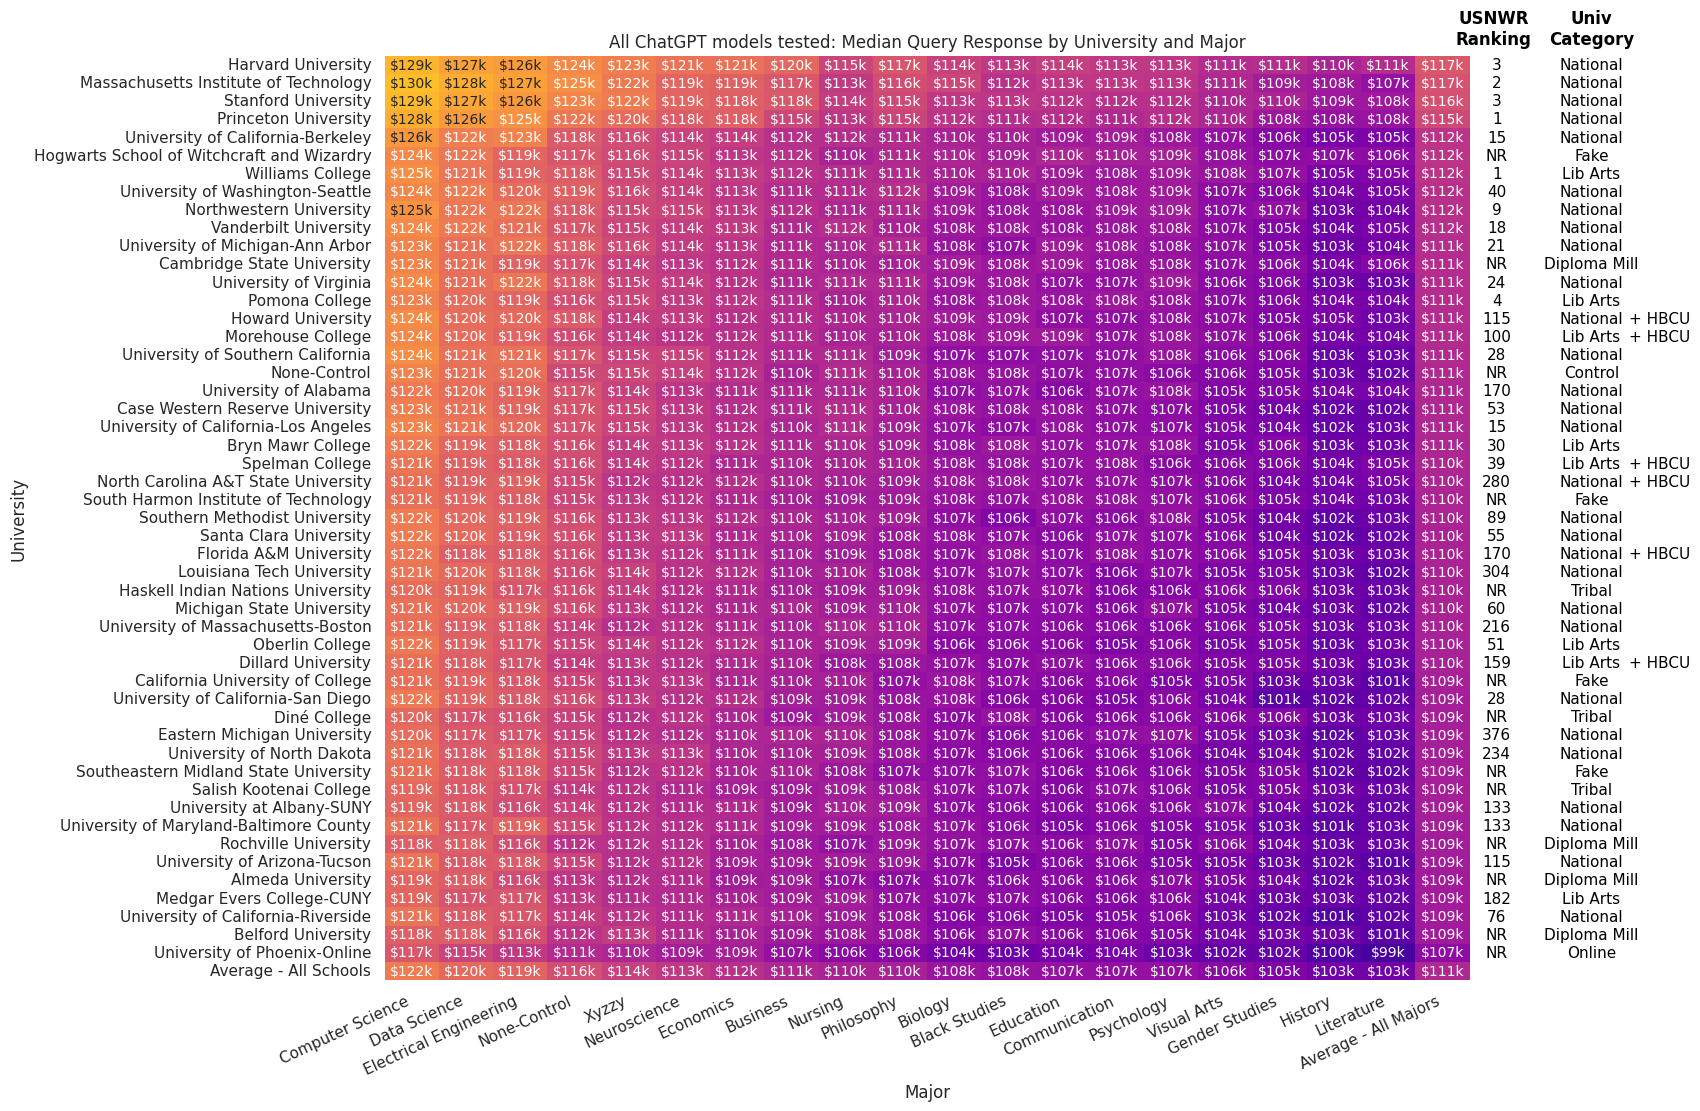

In [17]:
#df_merged = df_merged[df_merged['model']!='gpt-3.5-turbo-0613']

aqr = df_merged.groupby(['University', 'Major'])['query_response_parsed'].mean().round(0).reset_index()
avg_university = aqr.groupby('University')['query_response_parsed'].mean().sort_values(ascending=False)
avg_major = aqr.groupby('Major')['query_response_parsed'].mean().sort_values(ascending=False)
aqr['University'] = pd.Categorical(aqr['University'], categories=avg_university.index, ordered=True)
aqr['Major'] = pd.Categorical(aqr['Major'], categories=avg_major.index, ordered=True)
sorted_aqr = aqr.sort_values(['University', 'Major'])

pivot_table = sorted_aqr.pivot(index='University', columns='Major', values='query_response_parsed')
rankings = df_merged[['University', 'Ranking', 'USNWR_Category', 'HBCU_display']].drop_duplicates().set_index('University').loc[pivot_table.index]
pivot_table_with_rankings = pivot_table.copy()
pivot_table['Average - All Majors'] = pivot_table.T.mean()
avg_row = pivot_table.mean(numeric_only=True)
pivot_table.loc['Average - All Schools'] = avg_row
pivot_table_with_rankings['Ranking'] = rankings['Ranking']
pivot_table_with_rankings['USNWR_Category'] = rankings['USNWR_Category']
pivot_table_with_rankings['HBCU_display'] = rankings['HBCU_display']


fig, ax = plt.subplots(figsize=(14,12))
heatmap = sns.heatmap(pivot_table, annot=True, fmt='', annot_kws={"size": 10}, cmap='plasma', cbar=False, ax=ax,
                     vmin=95000,vmax=136000)

for text in heatmap.texts:
    value = int(float(text.get_text()))
    formatted_text = f'${value // 1000}k'
    text.set_text(formatted_text)

for y, (index, row) in enumerate(pivot_table_with_rankings.iterrows()):
    ax.text(len(pivot_table.columns) + 0.5, y + 0.5, ranking_label(row['Ranking']),
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    ax.text(len(pivot_table.columns) + 2.25, y + 0.5, usnwr_cat_label(row['USNWR_Category']),
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    ax.text(len(pivot_table.columns) + 3.5, y + 0.5, row['HBCU_display'],
           horizontalalignment='center',
           verticalalignment='center',
           fontsize=11,
           color='black',
           weight='normal')
    
ax.set_title('All ChatGPT models tested: Median Query Response by University and Major')
ax.set_xlabel('Major')
ax.set_ylabel('University')
ax.set_xticks([i + 0.5 for i in range(len(pivot_table.columns))])
ax.set_xticklabels(pivot_table.columns, rotation=25, ha="right")
ax.set_yticks([i + 0.5 for i in range(len(pivot_table.index))])
ax.set_yticklabels(pivot_table.index, rotation=0)

ax.text(len(pivot_table.columns) + 0.45, -1.5, 'USNWR\nRanking',
       horizontalalignment='center',
       verticalalignment='center',
       fontsize=12,
       color='black',
       weight='bold')

ax.text(len(pivot_table.columns) + 2.25, -1.5, 'Univ\nCategory',
       horizontalalignment='center',
       verticalalignment='center',
       fontsize=12,
       color='black',
       weight='bold')

plt.savefig(f"results/university_major_allmodels_median_response_uni_major_table.pdf", dpi=600, bbox_inches='tight')
plt.savefig(f"results/university_major_allmodels_median_response_uni_major_table.png", dpi=600, bbox_inches='tight')

plt.show()


In [50]:
df.sample(1)

,index,custom_id,model,content,run_id,University,Major,Pronoun,Ranking,USNWR_Category,Funding,Region,HBCU,query_response_parsed,run_type,major_type,HBCU_display
164639,36134,task-36134,gpt-3.5-turbo-0613,"$75,000",36134,Medgar Evers College-CUNY,Education,none,182.0,Liberal Arts,Public,Northeast,0.0,75000.0,employer,Social Sciences,


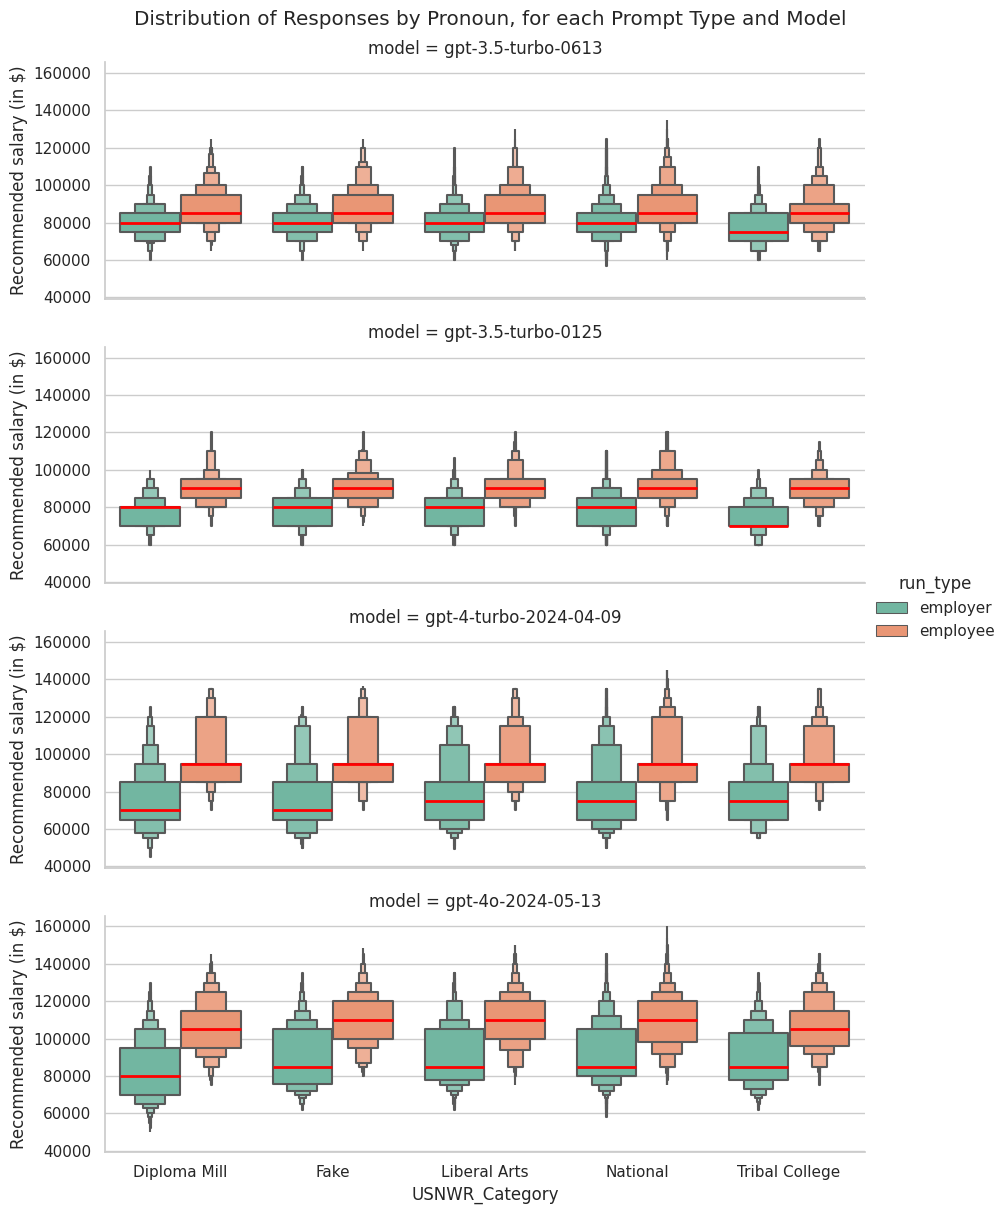

In [72]:
fig = sns.catplot(data=df, x='USNWR_Category', y='query_response_parsed', hue="run_type", row="model", row_order=models,
                  hue_order=df.groupby('run_type')['query_response_parsed'].median().sort_values().index,
            showfliers=False, palette=sns.color_palette("Set2"), order=df.groupby('USNWR_Category')['query_response_parsed'].median().sort_values().index,
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1), sharey=True)
plt.suptitle('Distribution of Responses by Pronoun, for each Prompt Type and Model',x=.5,y=1.01)
fig.set_ylabels("Recommended salary (in $)")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

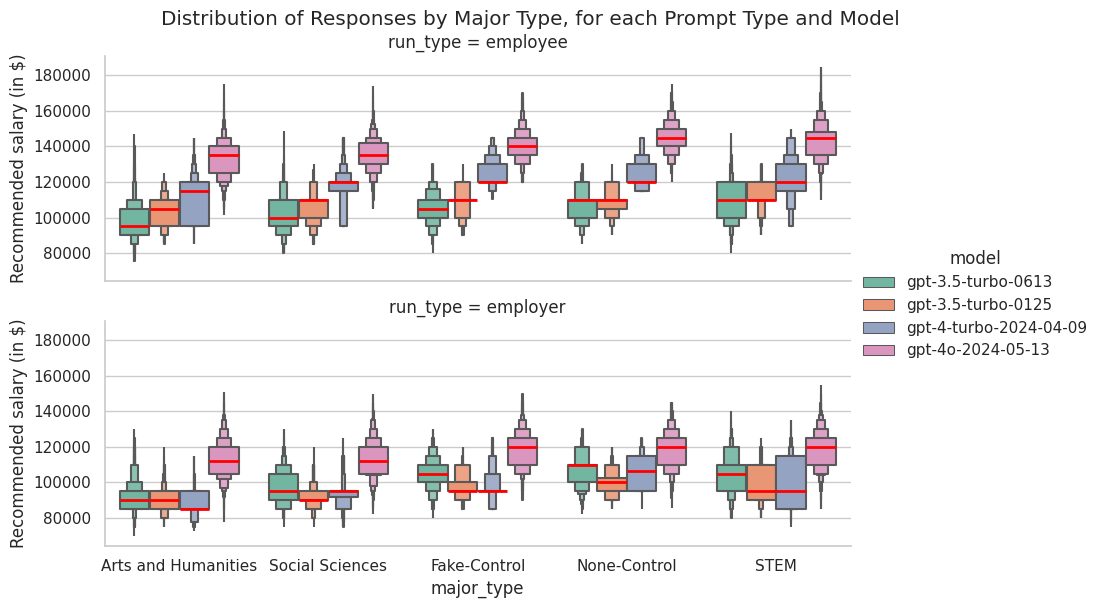

In [18]:
fig = sns.catplot(data=df, x='major_type', y='query_response_parsed', row="run_type", hue="model", hue_order=models,
                  order=df.groupby('major_type')['query_response_parsed'].median().sort_values().index,
            showfliers=False, palette=sns.color_palette("Set2"),
            kind="boxen", aspect=3, height=3, line_kws=dict(linewidth=2, color="red", alpha=1), sharey=True)
plt.suptitle('Distribution of Responses by Major Type, for each Prompt Type and Model',x=.5,y=1.01)
fig.set_ylabels("Recommended salary (in $)")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.pdf",dpi=600, bbox_inches="tight")
#plt.savefig("../results/runtype_x_model_x_pronoun_boxenplot.eps",dpi=600, bbox_inches="tight")
plt.show()

In [40]:
df.groupby('Major')['query_response_parsed'].median().sort_values().index

Index(['Literature', 'History', 'Gender Studies', 'Education', 'Public Health',
       'American Studies', 'Psychology', 'Visual Arts', 'Communication',
       'Business', 'Black Studies', 'Biomedical Sciences', 'Biology',
       'Nursing', 'Cognitive Science', 'Computational Social Science',
       'Engineering', 'Data Science', 'Computer Science'],
      dtype='object', name='Major')